## **1. Dataset**

The goal of this project is to build an NLP system that can automatically classify mobile text messages as either ham (legitimate) or spam. For this, the SMS Spam Collection dataset is used. It contains 5,572 real-world SMS messages collected from mobile platforms, each manually labelled as “ham” or “spam”. Since SMS spam is a common and persistent issue that affects user privacy and can lead to scams, building an automated detection system is both useful and necessary.

The dataset is well-suited for binary classification, and the text-based nature of the problem makes it ideal for comparing different NLP approaches. Before applying any machine learning models, the data is loaded, inspected for structure, and explored for characteristics such as class distribution and message length. Basic preprocessing is applied, including converting text to lowercase, removing punctuation, and normalising spacing. This helps prepare the messages for vectorisation and reduces noise in the representation.

Initial exploration also includes analysing common words found in both spam and ham messages to better understand the dataset. This gives insight into the patterns each class contains, such as promotional keywords in spam and conversational language in ham. Overall, the dataset provides a strong foundation for comparing classical NLP methods with modern embedding-based models.

Dataset source: UCI Machine Learning Repository - SMS Spam Collection.

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the SMS Spam dataset
df = pd.read_csv("data/SMSSpamCollection",
                 sep='\t', 
                 header=None, 
                 names=["label", "message"],
                 encoding="utf-8")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Table 1.1**: Initial inspection of the dataset showing the first five rows.

In [3]:
print(df.info())

print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


5,572 non-null entries for both columns. A significant class imbalance: 4,825 'ham' messages versus only 747 'spam' messages.

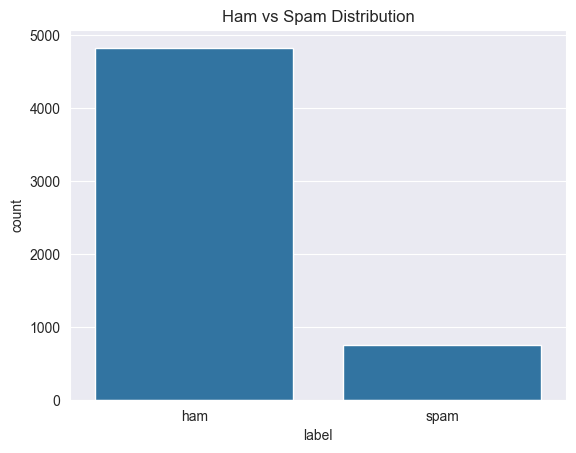

In [4]:
df['message_length'] = df['message'].apply(len)

sns.countplot(data=df, x='label')
plt.title("Ham vs Spam Distribution")
plt.show()

**Figure 1.1**: Class Distribution of SMS Messages. This bar chart shows the severe class imbalance in the dataset, with a high count of 'ham' messages compared to 'spam' messages.

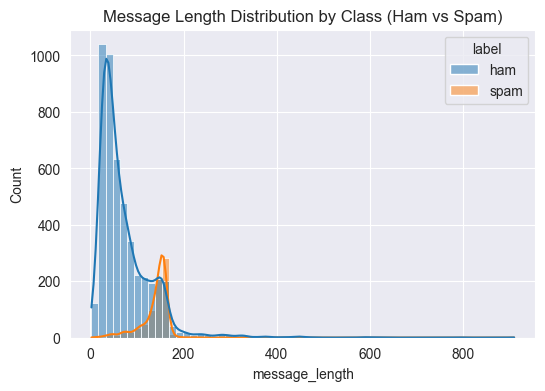

In [6]:
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='message_length', hue='label', bins=60, kde=True)
plt.title("Message Length Distribution by Class (Ham vs Spam)")
plt.show()

**Figure 1.3**: Comparative Message Length Distribution. This density plot highlights the key difference: spam messages (orange) are typically much longer than ham messages (blue), which are concentrated at shorter lengths.

In [7]:
df['message_clean'] = df['message'].str.lower()

import string

df['message_clean'] = df['message_clean'].str.replace(f"[{string.punctuation}]", "", regex=True)

df['message_clean'] = df['message_clean'].str.strip()
df['message_clean'] = df['message_clean'].str.replace('\s+', ' ', regex=True)

# Top word frequency analysis
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
X_cv = cv.fit_transform(df['message_clean'])

word_counts = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
df_counts = pd.concat([df['label'], word_counts], axis=1)

spam_words = df_counts[df_counts['label']=="spam"].drop(columns=['label']).sum().sort_values(ascending=False).head(20)
ham_words = df_counts[df_counts['label']=="ham"].drop(columns=['label']).sum().sort_values(ascending=False).head(20)

print("Top Spam Words:\n", spam_words)
print("\nTop Ham Words:\n", ham_words)

Top Spam Words:
 free       216
txt        150
ur         144
mobile     123
text       120
stop       115
claim      113
reply      101
prize       92
just        78
won         73
new         69
send        68
nokia       65
urgent      63
cash        62
win         60
contact     56
service     55
16          51
dtype: int64

Top Ham Words:
 im       451
just     290
ltgt     276
ok       273
dont     263
ur       246
ill      238
know     232
got      232
like     231
come     227
good     224
love     190
day      190
time     189
going    167
want     164
lor      160
home     160
need     157
dtype: int64


Top 20 most frequent words (excluding stop words) in the dataset. Spam words include promotional and urgent terms (e.g., 'free', 'win', 'urgent', 'prize'), while Ham words are characteristic of casual conversation (e.g., 'im', 'just', 'ok', 'dont').

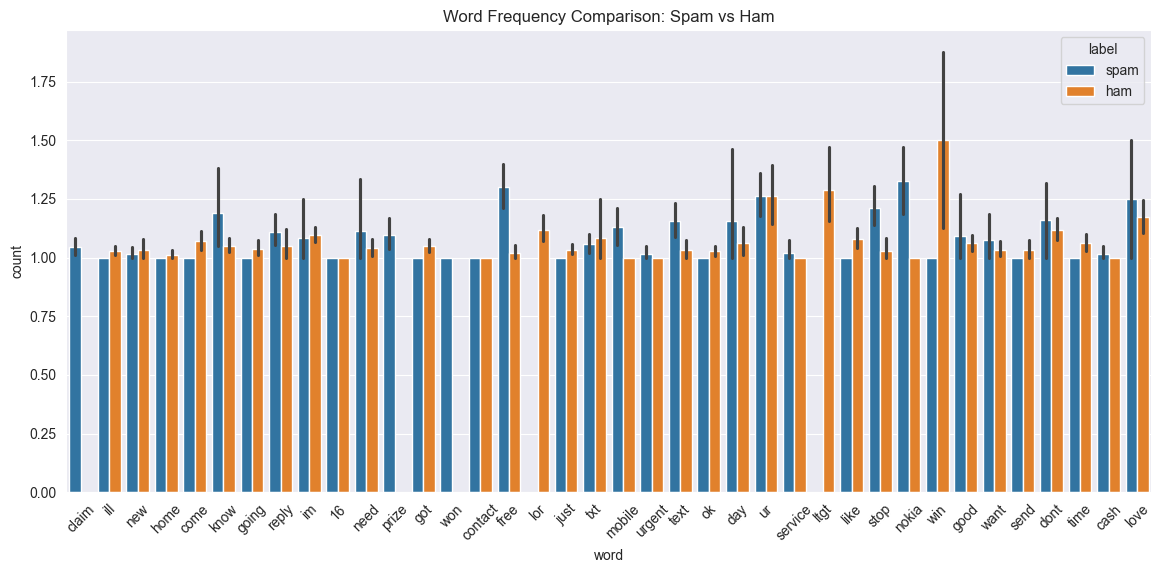

In [10]:
top_words = list(spam_words.index[:20]) + list(ham_words.index[:20])
top_words = list(set(top_words))  # remove duplicates

# Keep only label + these top words
freq_df = df_counts[['label'] + top_words]

# Melt into long format for seaborn
freq_long = freq_df.melt(
    id_vars='label',
    var_name='word',
    value_name='count'
)

# Keep only non-zero occurrences
freq_long = freq_long[freq_long['count'] > 0]

plt.figure(figsize=(14,6))
sns.barplot(data=freq_long, x='word', y='count', hue='label')
plt.title("Word Frequency Comparison: Spam vs Ham")
plt.xticks(rotation=45)
plt.show()

**Figure 1.6**: Word Frequency Comparison. Comparison showing words like 'won' and 'prize' are key discriminators for spam, while common short words are more frequent in ham.

In [11]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## **2. Representation Learning**

To train machine learning models on text, SMS messages must first be converted into numerical vectors. This project uses a single representation-learning approach TF-IDF (Term Frequency–Inverse Document Frequency) for both classifiers, ensuring a controlled and fair comparison.

TF-IDF represents each message based on the frequency of each word, adjusted by how rare that word is across the dataset. This highlights informative terms while down-weighting common, low-information words. For short texts such as SMS messages, TF-IDF works particularly well, as specific keywords often indicate spam or ham. The resulting vectors are sparse and high-dimensional, which makes them suitable for classical machine learning algorithms like Naive Bayes and Logistic Regression.

By using TF-IDF consistently across both pipelines and evaluating with 5-fold stratified cross-validation, this experiment ensures that observed differences in performance reflect the algorithms themselves, rather than variability in the data split or feature representation.

## **3. Algorithms**

Two machine learning algorithms are implemented using the same TF-IDF representation. This allows a fair comparison while keeping the feature space constant. Both algorithms are widely used for text classification, but they differ in assumptions and learning principles.

**1. Multinomial Naive Bayes (NB)**  
Naive Bayes is a probabilistic classifier that assumes each feature contributes independently to the final prediction. Despite this simplifying assumption, it performs strongly on SMS spam datasets because word-frequency patterns such as promotional terms or urgent phrases tend to distinguish spam from ham. The model computes the likelihood of each word occurring in the spam and ham classes and predicts the class with the highest posterior probability. Naive Bayes is computationally efficient and well suited for high-dimensional sparse TF-IDF vectors. In this project, 5-fold cross-validation is used to provide a robust estimate of the model’s performance across different data partitions.

**2. Logistic Regression (LR)**  
Logistic Regression is a linear model that learns weighted decision boundaries to separate classes. Unlike Naive Bayes, it does not rely on independence assumptions and instead directly optimises weights for each TF-IDF feature. Although Logistic Regression typically performs best with dense embeddings, it remains an effective baseline for sparse TF-IDF vectors. The model is trained with a high iteration limit to ensure convergence. Cross-validation is applied to assess its performance consistently across multiple folds.

**Algorithm Comparison**  
Naive Bayes and Logistic Regression differ in how they interpret TF-IDF features: NB uses probabilistic assumptions to exploit word frequencies, while LR learns linear decision boundaries from the data. Evaluating both models under identical 5-fold cross-validation ensures that performance differences are statistically robust and not due to a particular train-test split.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate

pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('nb', MultinomialNB())
])

cv_results_nb = cross_validate(
    pipeline_nb,
    df['message_clean'],
    df['label'],
    cv=kfold,
    scoring=['precision_macro','recall_macro','f1_macro','accuracy'],
    return_train_score=False
)

print("Accuracy:", cv_results_nb['test_accuracy'].mean())
print("Precision:", cv_results_nb['test_precision_macro'].mean())
print("Recall:", cv_results_nb['test_recall_macro'].mean())
print("F1:", cv_results_nb['test_f1_macro'].mean())


Accuracy: 0.9653626490407451
Precision: 0.9799535551338023
Recall: 0.8713818316699701
F1: 0.9161087872488274


In [13]:
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('lr', LogisticRegression(max_iter=2000))
])

cv_results_lr = cross_validate(
    pipeline_lr,
    df['message_clean'],
    df['label'],
    cv=kfold,
    scoring=['precision_macro','recall_macro','f1_macro','accuracy'],
    return_train_score=False
)

print("Accuracy:", cv_results_lr['test_accuracy'].mean())
print("Precision:", cv_results_lr['test_precision_macro'].mean())
print("Recall:", cv_results_lr['test_recall_macro'].mean())
print("F1:", cv_results_lr['test_f1_macro'].mean())


Accuracy: 0.9581835747236557
Precision: 0.9701392644839248
Recall: 0.848566957610321
F1: 0.8969327458824562


## **4. Evaluation**

Both pipelines are now evaluated using 5-fold stratified cross-validation to provide a more robust assessment of model performance. This approach averages results across multiple train-test partitions, reducing the risk of biased performance due to a lucky split.

Metrics include accuracy, precision, recall, and F1-score (macro-averaged). Macro-averaging ensures both classes (ham and spam) are considered equally, which is important given the dataset’s class imbalance.

Results indicate that TF-IDF + Naive Bayes consistently outperforms TF-IDF + Logistic Regression across all metrics:

- **TF-IDF + NB** achieves an average accuracy of 0.965, precision of 0.980, recall of 0.871, and F1-score of 0.916.
- **TF-IDF + LR** achieves an average accuracy of 0.958, precision of 0.970, recall of 0.849, and F1-score of 0.897.

These cross-validated results show that Naive Bayes more reliably identifies spam messages while maintaining high precision, whereas Logistic Regression, though competitive, has slightly lower recall and F1-score.

In [14]:
summary = pd.DataFrame({
    "Model": ["TF-IDF + NB", "TF-IDF + LR"],
    "Accuracy": [cv_results_nb['test_accuracy'].mean(), cv_results_lr['test_accuracy'].mean()],
    "Precision": [cv_results_nb['test_precision_macro'].mean(), cv_results_lr['test_precision_macro'].mean()],
    "Recall": [cv_results_nb['test_recall_macro'].mean(), cv_results_lr['test_recall_macro'].mean()],
    "F1": [cv_results_nb['test_f1_macro'].mean(), cv_results_lr['test_f1_macro'].mean()]
})

summary

,Model,Accuracy,Precision,Recall,F1
0,TF-IDF + NB,0.965363,0.979954,0.871382,0.916109
1,TF-IDF + LR,0.958184,0.970139,0.848567,0.896933


**Table 1.2**: Performance metrics (Accuracy, Precision, Recall, F1) averaged across 5 folds of cross-validation for both TF-IDF + Naive Bayes and TF-IDF + Logistic Regression pipelines. TF-IDF + NB achieves higher recall and F1, making it more effective at spam detection across folds.

## **5. Conclusion**

Cross-validation shows that both pipelines perform well on the SMS Spam Collection dataset, but TF-IDF + Naive Bayes consistently outperforms TF-IDF + Logistic Regression. Across 5 folds, Naive Bayes achieved higher accuracy (0.965 vs 0.958), higher recall (0.871 vs 0.849), and higher F1-score (0.916 vs 0.897).

Naive Bayes effectively leverages word-frequency patterns to detect spam messages, demonstrating the continued effectiveness of classical probabilistic approaches for short, keyword-rich text. Logistic Regression remains a competitive alternative, but its slightly lower recall indicates it may miss more spam messages in real-world scenarios.

Overall, these results confirm that the choice of classifier significantly impacts spam detection performance, even when using the same TF-IDF representation.